# EECS 598 Lab 6: Mujoco Playground Suite & External RL Libraries

![lab6_poster](media/lab06_poster.png)

This notebook is worth **80 points**. Your score will be calculated as `score = min(score, 80)`.
Questions and implementations are marked with relevent `#TODO(student)` markers.

Before starting the assignment, please put your name and UMID in the following format:

Firstname LASTNAME, #00000000 (ex. Drew SCHEFFER #31415926)

**YOUR ANSWER**

SHIVAM UDESHI, 87841376

## Setup

In [1]:
import sys, types, importlib

# Create a tiny fake 'imp' module exposing only 'reload'
_imp = types.ModuleType("imp")
_imp.reload = importlib.reload
sys.modules["imp"] = _imp

# load autoreload
%load_ext autoreload
%autoreload 2

In [2]:
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl
%env XLA_PYTHON_CLIENT_PREALLOCATE=false

Setting environment variable to use GPU rendering:
env: MUJOCO_GL=egl
env: XLA_PYTHON_CLIENT_PREALLOCATE=false


In [3]:
#@title Import packages for plotting and creating graphics
import time
import itertools
import numpy as np
from typing import Callable, NamedTuple, Optional, Union, List

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

Installing mediapy:
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.7 MB/s eta 0:00:00


### Google Colab Setup

Next, we'll run a few commands to set up the environment on Google Colab. If you are running this notebook locally you can skip this section

Run the following to mount this notebook to your Google Drive. Follow the link and sign into the Google account following the prompts. Use the same Google account that you used to store this notebook.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Now update the path below to point to the folder in your Google Drive where you uploaded this notebook. If everything worked correctly you should see the following filenames at least: [`06_lab_student.ipynb`, `CSE598RSLWrapper.py`]

In [5]:
import os

# TODO: Fill in the Google Drive path where you uploaded project 2
# Example: If you create a 2025FA folder and put all the files under Lab6, then '2025FA/Lab6'
# GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = '2025FA/Lab6'

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = '/content/drive/MyDrive/CSE_598/lab6-playground-rsl/lab6-playground-rsl'
GOOGLE_DRIVE_PATH_LAB6 = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)

print(os.listdir(GOOGLE_DRIVE_PATH_LAB6))

# Add to path and change directory for good measure
sys.path.append(GOOGLE_DRIVE_PATH_LAB6)
os.chdir(GOOGLE_DRIVE_PATH_LAB6)

['custom_domain_randomize.py', '.DS_Store', 'CSE598RSLWrapper.py', 'custom_go1_locomote.py', 'checkpoints', 'media', '06_lab_student.ipynb']


In [6]:
from google.colab import files

import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

## Mujoco, JAX, MJX, BRAX, and Playground Setup & Imports

In [7]:
!pip install mujoco
!pip install mujoco_mjx
!pip install brax
!pip install noise

# TODO(student): If you're running this locally, make sure to install cuda enabled jax via something like:
# !pip install "jax[cuda12]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.5/243.5 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 735.5/735.5 kB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.1/344.1 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.4/172.4 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for noise: filename=noise-1.2.2-cp312-cp312-linux_x86_64.whl size=56631 sha256=4d66042e8aa9a99353fb4f577baffa79598272d055eae9816786b47357214317
  St

In [8]:
!pip install playground
!pip install "rsl-rl-lib<3.0.0"
!pip install wandb
!pip install tensorboard

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 47.5 MB/s eta 0:00:00


In [9]:
import os

try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Tell XLA to use Triton GEMM, this improves steps/sec by ~30% on some GPUs
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags

Checking that the installation succeeded:
Installation successful.


Ensure that the output of the following cell is `[CudaDevice(id=0)]`

In [10]:
import jax
print(jax.devices())

[CudaDevice(id=0)]


In [11]:
#@title Import MuJoCo, MJX, and Brax
from datetime import datetime
from etils import epath
import functools
from IPython.display import HTML
from typing import Any, Dict, Sequence, Tuple, Union
import os
from ml_collections import config_dict


import jax
from jax import numpy as jp
import numpy as np
from flax.training import orbax_utils
from flax import struct
from matplotlib import pyplot as plt
import mediapy as media
from orbax import checkpoint as ocp

import mujoco
from mujoco import mjx

from brax import base
from brax import envs
from brax import math
from brax.base import Base, Motion, Transform
from brax.base import State as PipelineState
from brax.envs.base import Env, PipelineEnv, State
from brax.mjx.base import State as MjxState
from brax.training.agents.ppo import train as ppo
from brax.training.agents.ppo import networks as ppo_networks
from brax.io import html, mjcf, model

Failed to import warp: No module named 'warp'
Failed to import mujoco.mjx.third_party.mujoco_warp as mujoco_warp: No module named 'warp'


In [12]:

import os

xla_flags = os.environ.get("XLA_FLAGS", "")
xla_flags += " --xla_gpu_triton_gemm_any=True"
os.environ["XLA_FLAGS"] = xla_flags
os.environ["MUJOCO_GL"] = "egl"

from datetime import datetime
import json

from absl import app
from absl import flags
from absl import logging
import jax
import mediapy as media
from ml_collections import config_dict
import mujoco
from rsl_rl.runners import OnPolicyRunner
import torch
# import wandb

import mujoco_playground
from mujoco_playground import registry
from mujoco_playground import wrapper_torch
from mujoco_playground import wrapper
from mujoco_playground.config import locomotion_params
from mujoco_playground.config import manipulation_params
from mujoco_playground.config import dm_control_suite_params

# Suppress logs if you want
logging.set_verbosity(logging.WARNING)

mujoco_menagerie not found. Downloading...


Cloning mujoco_menagerie: ██████████| 100/100 [00:43<00:00]


Checking out commit 14ceccf557cc47240202f2354d684eca58ff8de4
Successfully downloaded mujoco_menagerie


# Playing around with the Full MujocoPlayground Stack!
Up until this point, we actually haven't used the full MujocoPlayground software stack. We have been implementing our environments and training loops entirely in the BRAX ecosystem. Playground offers a slightly different environment structure which is consistent among all of the environments that they impliment. Typically, however, they still use the JAX-based BRAX RL abstractions to train their agents. In this lab, we'll get more experience working with Mujoco Playground and interfacing it with a popular 3rd party RL library.

Below lists all the default environments that are implimented. Check out their [Github](https://github.com/google-deepmind/mujoco_playground/tree/main/mujoco_playground/_src/locomotion) to see the implementations. The code should look very similar to what you've seen in previous labs.

In [13]:
print("These are all of the implemented playground envs: \n", ", ".join(registry.ALL_ENVS))

These are all of the implemented playground envs: 
 AcrobotSwingup, AcrobotSwingupSparse, BallInCup, CartpoleBalance, CartpoleBalanceSparse, CartpoleSwingup, CartpoleSwingupSparse, CheetahRun, FingerSpin, FingerTurnEasy, FingerTurnHard, FishSwim, HopperHop, HopperStand, HumanoidStand, HumanoidWalk, HumanoidRun, PendulumSwingup, PointMass, ReacherEasy, ReacherHard, SwimmerSwimmer6, WalkerRun, WalkerStand, WalkerWalk, ApolloJoystickFlatTerrain, BarkourJoystick, BerkeleyHumanoidJoystickFlatTerrain, BerkeleyHumanoidJoystickRoughTerrain, G1JoystickFlatTerrain, G1JoystickRoughTerrain, Go1JoystickFlatTerrain, Go1JoystickRoughTerrain, Go1Getup, Go1Handstand, Go1Footstand, H1InplaceGaitTracking, H1JoystickGaitTracking, Op3Joystick, SpotFlatTerrainJoystick, SpotGetup, SpotJoystickGaitTracking, T1JoystickFlatTerrain, T1JoystickRoughTerrain, AlohaHandOver, AlohaSinglePegInsertion, PandaPickCube, PandaPickCubeOrientation, PandaPickCubeCartesian, PandaOpenCabinet, PandaRobotiqPushCube, LeapCubeReori

### Inspecting the environment implementations

`TODO(student):` Describe one similarity and one difference with how the environments are implemented in MujocoPlayground compared to our previous BRAX-based implementations. **(10 points)**

**Answer Here**
BRAX environments are implemented in pure JAX, which makes them differentiable and allows for massive parallelization on accelerators (TPUs/GPUs). The entire simulation is vectorized and JIT-compiled.

MujocoPlayground uses the MuJoCo physics engine as the backend. This is a compiled C++ engine wrapped in Python, prioritizing physical accuracy and stability, but not differentiable. Parallelization is done differently (via multiple processes or vectorized environments, not JAX compilation).




# Customizing an Environment / Task

Often times, when both learning about and doing research in reinforcement learning, one of the most effective ways to build understanding and develop new ideas is to start from a baseline that already works.
From there, making small, deliberate modifications (i.e. adjusting rewards, alterning the learning algorithm, or changing which state variables the agent observes) can uncover a great deal of insight.
In my experience, these incremental tweaks not only help highlight the role of the design choices, but also help develop intuition about what drives performance, potentially leading to breakthroughs.

In this section of the lab, I hope that you get a chance to experiment with this kind of play/debugging. Specifically, I'll ask you to build on top of at least one environment implemented in Playground, and
compare it to the default environment. Basically... modify something!

Here's a non-exhaustive list of some example modifications:
- Add / Delete / change a reward term
- Give the policy an observations that that it may not have access to in the real world (e.g. terrain friction, depth of terrain, etc)
- Remove or periodically stiffen one of the legs (fault recovery)
- Change the direction / magnitude of the gravity vector
- Change the noise level of the observations
- Simulate Sensor Latency
- Change what's randomized during training

`TODO(student):` Describe the MujocoPlayground environment that you intend to work with, and the environment modification that you intend to make. Give a hypothesis for the effect of your modification on the learned policy. How could you measure / test that hypothesis (Is it something that is evident in a video rollout? Do you need to plot anything)?  **(40 points)**

**\[Answer Here\]**

The environment I am using is Go1JoystickFlatTerrain, where a simulated quadruped robot must follow joystick commands while maintaining stable locomotion on flat terrain. The agent receives proprioceptive observations including joint positions, velocities, body orientation, and linear and angular velocities, and the reward encourages accurate command tracking, energy efficiency, and proper foot placement. The modification I implemented is to vary the observation noise level, which adds Gaussian noise to sensors such as joint positions, velocities, and gravity, simulating imperfect real-world measurements. Policies trained without noise are expected to perform well under clean observations but may degrade when tested with higher sensor noise, resulting in poorer command tracking and less stable gaits. By evaluating the baseline policy under three noise conditions—low, medium, and high—we can measure how sensitive it is to observational uncertainty. Metrics include cumulative episode reward across multiple rollouts, as well as reward component breakdowns to identify which aspects of performance are most affected. Visualization includes line plots of mean reward ± standard deviation across noise levels and horizontal stacked bar plots showing reward contributions per component. The goal is to assess whether the baseline policy can generalize under different levels of observation noise and identify which reward components are most impacted by increased sensor uncertainty.

## Training / Testing a Baseline Policy

First, get the default environment configuration for your selected environment. This specifies things like reward constants, noise values, PD values, etc.

In [42]:
 #TODO(student): Change this to the playground environment you want to work with. Pretrained model checkpoints are available for the "Go1Getup" and "Go1JoystickFlatTerrain" environments for your convenience
env_name = "Go1JoystickFlatTerrain"

env = registry.load(env_name)
env_cfg = registry.get_default_config(env_name)
env_cfg

Kd: 0.5
Kp: 35.0
action_repeat: 1
action_scale: 0.5
command_config:
  a:
  - 1.5
  - 0.8
  - 1.2
  b:
  - 0.9
  - 0.25
  - 0.5
ctrl_dt: 0.02
episode_length: 1000
history_len: 1
noise_config:
  level: 1.0
  scales:
    gravity: 0.05
    gyro: 0.2
    joint_pos: 0.03
    joint_vel: 1.5
    linvel: 0.1
pert_config:
  enable: false
  kick_durations:
  - 0.05
  - 0.2
  kick_wait_times:
  - 1.0
  - 3.0
  velocity_kick:
  - 0.0
  - 3.0
reward_config:
  max_foot_height: 0.1
  scales:
    action_rate: -0.01
    ang_vel_xy: -0.05
    dof_pos_limits: -1.0
    energy: -0.001
    feet_air_time: 0.1
    feet_clearance: -2.0
    feet_height: -0.2
    feet_slip: -0.1
    lin_vel_z: -0.5
    orientation: -5.0
    pose: 0.5
    stand_still: -1.0
    termination: -1.0
    torques: -0.0002
    tracking_ang_vel: 0.5
    tracking_lin_vel: 1.0
  tracking_sigma: 0.25
sim_dt: 0.004
soft_joint_pos_limit_factor: 0.95

Next, get the standard BRAX RL configuration for an MLP policy trained with PPO.

In [43]:

from mujoco_playground.config import locomotion_params
ppo_params = locomotion_params.brax_ppo_config(env_name)
ppo_params.num_timesteps = 200_000_000

ppo_params

action_repeat: 1
batch_size: 256
discounting: 0.97
entropy_cost: 0.01
episode_length: 1000
learning_rate: 0.0003
max_grad_norm: 1.0
network_factory:
  policy_hidden_layer_sizes: &id001 !!python/tuple
  - 512
  - 256
  - 128
  policy_obs_key: state
  value_hidden_layer_sizes: *id001
  value_obs_key: privileged_state
normalize_observations: true
num_envs: 8192
num_evals: 10
num_minibatches: 32
num_resets_per_eval: 1
num_timesteps: 200000000
num_updates_per_batch: 4
reward_scaling: 1.0
unroll_length: 20

Get the domain randomizer... Very similar to what you implemented in `Lab04`. This domain randomization function randomizes over friction, armature, center of mass of the torso, and link masses, amongst other simulation parameters. See the [implementation here](https://github.com/google-deepmind/mujoco_playground/blob/main/mujoco_playground/_src/locomotion/go1/randomize.py).

In [44]:
# from custom_domain_randomize import custom_domain_randomize
# randomizer = custom_domain_randomize # Custom randomizer

randomizer = registry.get_domain_randomizer(env_name) # Default randomizer

Set up the brax training function. This should look almost identical to what was implemented in `Lab05`, however note the additional `wrapper.wrap_for_brax_training`.

In [45]:
from IPython.display import HTML, clear_output

x_data, y_data, y_dataerr = [], [], []
times = [datetime.now()]


def progress_callback(num_steps, metrics):
  clear_output(wait=True)

  times.append(datetime.now())
  x_data.append(num_steps)
  y_data.append(metrics["eval/episode_reward"])
  y_dataerr.append(metrics["eval/episode_reward_std"])

  plt.xlim([0, ppo_params["num_timesteps"] * 1.25])
  plt.xlabel("# environment steps")
  plt.ylabel("reward per episode")
  plt.title(f"y={y_data[-1]:.3f}")
  plt.errorbar(x_data, y_data, yerr=y_dataerr, color="blue")

  display(plt.gcf())

ppo_training_params = dict(ppo_params)
network_factory = ppo_networks.make_ppo_networks
if "network_factory" in ppo_params:
  del ppo_training_params["network_factory"]
  network_factory = functools.partial(
      ppo_networks.make_ppo_networks,
      **ppo_params.network_factory
  )

train_fn = functools.partial(
    ppo.train, **dict(ppo_training_params),
    network_factory=network_factory,
    randomization_fn=randomizer,
    progress_fn=progress_callback,
    # TODO(student): Note the below change from previous labs.
    # The env we're working with isn't BRAX, so we have to wrap it to be compatible with brax RL training...
    wrap_env_fn=wrapper.wrap_for_brax_training,
    seed=598
)

In the cell below, you'll either train your BRAX policy from scratch or load from a checkpoint. Given COLAB usage limits, I've provided checkpoints as baselines in the `./checkpoints` directory along with their corresponding training plots.

In [46]:

TRAIN_POLICY = False

if TRAIN_POLICY:
    # Running the below will TRAIN the policy from scratch

    make_inference_fn, params, metrics = train_fn(
        environment=env,
        eval_env=registry.load(env_name, config=env_cfg),
    )
    print(f"time to jit: {times[1] - times[0]}")
    print(f"time to train: {times[-1] - times[1]}")

    # Save the model

    # TODO(student): You may have to change the checkpoint below based on which environment you used
    model_path = './checkpoints/go1joystickflat_custom'
    model.save_params(model_path, params)
    params = model.load_params(model_path)
else:
    # Running the below will load a pretrained policy from a checkpoint
    make_inference_fn, params, metrics = train_fn(
        environment=env,
        eval_env=registry.load(env_name, config=env_cfg),
        wrap_env_fn=wrapper.wrap_for_brax_training,
        num_timesteps = 0,
    )

    # TODO(student): You may have to change the checkpoint below based on which environment you used
    model_path = './checkpoints/go1joystickflat_default'
    params = model.load_params(model_path)


##### Rollout & render the baseline policy

In [47]:
# Perform the jitting
env_cfg = registry.get_default_config(env_name)
eval_env = registry.load(env_name, config=env_cfg)

jit_reset = jax.jit(eval_env.reset)
jit_step = jax.jit(eval_env.step)
jit_inference_fn = jax.jit(make_inference_fn(params, deterministic=True))
rand_idx = 12

In [48]:
# Do a rollout
from mujoco_playground._src.gait import draw_joystick_command

x_vel = 1.0
y_vel = 0.0
yaw_vel = 0


rand_idx = rand_idx + 1
rng = jax.random.PRNGKey(rand_idx)
rollout = []
modify_scene_fns = []

rewards = []
foot_vel = []
rews = []
contact = []
command = jp.array([x_vel, y_vel, yaw_vel])

state = jit_reset(rng)

for i in range(env_cfg.episode_length):
    act_rng, rng = jax.random.split(rng)
    ctrl, _ = jit_inference_fn(state.obs, act_rng)
    state = jit_step(state, ctrl)

    rews.append(
        {k: v for k, v in state.metrics.items() if k.startswith("reward/")}
    )
    rollout.append(state)
    rewards.append(
        {k[7:]: v for k, v in state.metrics.items() if k.startswith("reward/")}
    )

    # Render the joystick command as an arrow, if applicable.
    if "joystick" in env_name.lower():
        state.info["command"] = command
        xyz = np.array(state.data.xpos[env._torso_body_id])
        xyz += np.array([0, 0, 0.2])
        x_axis = state.data.xmat[env._torso_body_id, 0]
        yaw = -np.arctan2(x_axis[1], x_axis[0])
        modify_scene_fns.append(
            functools.partial(
                draw_joystick_command,
                cmd=state.info["command"],
                xyz=xyz,
                theta=yaw,
                scl=abs(state.info["command"][0])
                / env_cfg.command_config.a[0],
            )
        )

In [49]:
# Render the rollout

render_every = 2
fps = 1.0 / eval_env.dt / render_every
traj = rollout[::render_every]

if "joystick" in env_name.lower():
    mod_fns = modify_scene_fns[::render_every]
else:
    mod_fns = None

scene_option = mujoco.MjvOption()
scene_option.geomgroup[2] = True
scene_option.geomgroup[3] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_PERTFORCE] = False

frames = eval_env.render(
    traj,
    camera="track",
    scene_option=scene_option,
    width=640,
    height=480,
    modify_scene_fns=mod_fns,
)
media.show_video(frames, fps=fps, loop=False)

Output hidden; open in https://colab.research.google.com to view.

## Environment Modification Code

`TODO(student):` Here, write any code you need to to compare your "modified environment" to a baseline environment above. Create some visualization about what changed/didn't change. Below, write a brief explaination of the effect your modification had, and if it corresponds to your hypothesis **(40 points)**



ENV MODIFICATION: Noise Level Experiment (Go1JoystickFlatTerrain)
Noise Level 0.0: Mean Reward = 2.50 ± 0.21
Noise Level 0.5: Mean Reward = 2.91 ± 0.12
Noise Level 1.0: Mean Reward = 2.82 ± 0.35


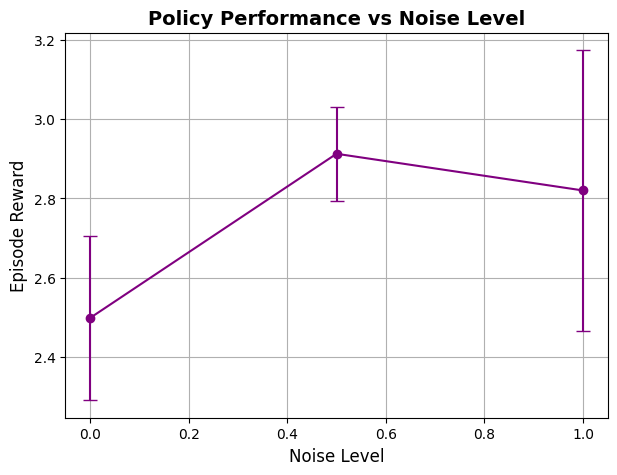

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import jax

print("="*60)
print("ENV MODIFICATION: Noise Level Experiment (Go1JoystickFlatTerrain)")
print("="*60)

# --- Experiment parameters ---
noise_levels = [0.0, 0.5, 1.0]   # low, medium, high
num_rollouts = 3
episode_length = 100  # shorter for fast testing

baseline_rewards = {n: [] for n in noise_levels}

for noise in noise_levels:
    # --- create environment with specific noise ---
    test_cfg = registry.get_default_config("Go1JoystickFlatTerrain")
    test_cfg.noise_config.level = noise
    test_cfg.episode_length = episode_length
    test_env = registry.load("Go1JoystickFlatTerrain", config=test_cfg)

    jit_reset = jax.jit(test_env.reset)
    jit_step  = jax.jit(test_env.step)

    for rollout_idx in range(num_rollouts):
        rng = jax.random.PRNGKey(rollout_idx + int(noise*1000))
        state = jit_reset(rng)

        total_reward = 0.0
        for step_idx in range(episode_length):
            act_rng, rng = jax.random.split(rng)
            ctrl, _ = jit_inference_fn(state.obs, act_rng)
            state = jit_step(state, ctrl)
            total_reward += float(state.reward)

        baseline_rewards[noise].append(total_reward)

    mean_r = np.mean(baseline_rewards[noise])
    std_r  = np.std(baseline_rewards[noise])
    print(f"Noise Level {noise}: Mean Reward = {mean_r:.2f} ± {std_r:.2f}")

# --- Visualization ---
fig, ax = plt.subplots(figsize=(7,5))
means = [np.mean(baseline_rewards[n]) for n in noise_levels]
stds  = [np.std(baseline_rewards[n]) for n in noise_levels]

ax.errorbar(noise_levels, means, yerr=stds, fmt='-o', capsize=5, color='purple')
ax.set_xlabel("Noise Level", fontsize=12)
ax.set_ylabel("Episode Reward", fontsize=12)
ax.set_title("Policy Performance vs Noise Level", fontsize=14, fontweight='bold')
ax.grid(True)
plt.show()


# Using Other External RL Libraries (rsl_rl)

In this section, we'll investigate how to interface with *different* RL libraries beyond the BRAX RL implimenations we've experimented with in mujoco_playground. Specificially, we'll focus on the popular [RSL_RL](https://github.com/leggedrobotics/rsl_rl) library, a fast and simple implimentation of RL algorithms designed to run fully on the GPU. It also provides nice logging/visualization. It's built to be small, modular, and relatively easy to read. In the next lab, we'll extend on the codebase to enable some more complicated learning architectures.

The `RSL_RL` reinforcment learning library is built entirely using [PyTorch](https://pytorch.org/). Notably this is different than the [JAX](https://github.com/jax-ml/jax)-based RL library bundled with mujoco-playground. To use RSL_RL, we'll need to make sure our environment conforms to the interface RSL_RL expects. We'll make an environment *wrapper* (parent class) that exposes observations, rewards, and resets as PyTorch tensors, supports batched execution for many environments in parallel, and keeps all data on the GPU to avoid unnecessary slowdowns. Additionally, we'll change some necessary configuration files.


We'll train on the `CheetahRun` environment from the `DeepMindControlSuite`. Below, we setup some global variables

In [66]:
# Setup some global variables
_ENV_NAME = "CheetahRun" # from deepmind_control_suite
_LOAD_RUN_NAME = None
_CHECKPOINT_NUM = -1
_PLAY_ONLY = False
_USE_WANDB = False
_SUFFIX = None
_SEED = 1
_NUM_ENVS = 4096
_DEVICE = "cuda:0"

device=_DEVICE

print(f" All Envs in MujocoPlayground: {', '.join(mujoco_playground.registry.ALL_ENVS)}")

 All Envs in MujocoPlayground: AcrobotSwingup, AcrobotSwingupSparse, BallInCup, CartpoleBalance, CartpoleBalanceSparse, CartpoleSwingup, CartpoleSwingupSparse, CheetahRun, FingerSpin, FingerTurnEasy, FingerTurnHard, FishSwim, HopperHop, HopperStand, HumanoidStand, HumanoidWalk, HumanoidRun, PendulumSwingup, PointMass, ReacherEasy, ReacherHard, SwimmerSwimmer6, WalkerRun, WalkerStand, WalkerWalk, ApolloJoystickFlatTerrain, BarkourJoystick, BerkeleyHumanoidJoystickFlatTerrain, BerkeleyHumanoidJoystickRoughTerrain, G1JoystickFlatTerrain, G1JoystickRoughTerrain, Go1JoystickFlatTerrain, Go1JoystickRoughTerrain, Go1Getup, Go1Handstand, Go1Footstand, H1InplaceGaitTracking, H1JoystickGaitTracking, Op3Joystick, SpotFlatTerrainJoystick, SpotGetup, SpotJoystickGaitTracking, T1JoystickFlatTerrain, T1JoystickRoughTerrain, AlohaHandOver, AlohaSinglePegInsertion, PandaPickCube, PandaPickCubeOrientation, PandaPickCubeCartesian, PandaOpenCabinet, PandaRobotiqPushCube, LeapCubeReorient, LeapCubeRotateZA

### Modify Some Configuration Files

First, we'll define a configuration file for our CheetahRun Environment. We'll set up an `ActorCritic` policy using the `PPO` algorithm.

`TODO(student):` Fill in the TODOs below. To find out what parameters are necessary do some sleuthing around the [rsl_rl repo](https://github.com/leggedrobotics/rsl_rl/tree/750e84566d91877a8bbabc7971578be24429bca8)

In [67]:
def rsl_rl_cheetah_config() -> config_dict.ConfigDict:
  """Returns tuned RSL-RL PPO config for the CheetahRun environment."""

  rl_config = config_dict.create(
      seed=1,
      runner_class_name="OnPolicyRunner",
      policy=config_dict.create(
          class_name='ActorCritic',
          init_noise_std=1.0,
          actor_hidden_dims=[256, 256, 256],
          critic_hidden_dims=[256, 256, 256],
          activation='elu',
      ),
      algorithm=config_dict.create(
          class_name='PPO',  # <-- THIS WAS MISSING!
          value_loss_coef=1.0,
          use_clipped_value_loss=True,
          clip_param=0.2,
          entropy_coef=0.01,
          num_learning_epochs=5,
          num_mini_batches=4,
          learning_rate=1.0e-3,
          schedule='adaptive',
          gamma=0.99,
          lam=0.95,
          desired_kl=0.01,
          max_grad_norm=1.0,
      ),
      num_steps_per_env=24,  # per iteration
      max_iterations=100000,  # number of policy updates
      empirical_normalization=True,

      # logging
      save_interval=50,  # check for potential saves every this many iterations
      experiment_name="eecs598_dm_control",
      run_name="",

      # load and resume
      resume=False,
      load_run="-1",  # -1 = last run
      checkpoint=-1,  # -1 = last saved model
      resume_path=None,  # updated from load_run and chkpt
  )

  return rl_config

Inspect the Environment Config and the RSL_RL Training Config.

In [68]:
# 1. Come up with an experiment name...
now = datetime.now()
timestamp = now.strftime("%Y%m%d-%H%M%S")
exp_name = f"{_ENV_NAME}-{timestamp}"
if _SUFFIX is not None:
    exp_name += f"-{_SUFFIX}"
print(f"Experiment name: {exp_name}")


# 2. Load default CheetahRun environment config from registry
env_cfg = registry.get_default_config(_ENV_NAME)
print(f"-------- Environment config --------\n{env_cfg}")

# 3. Load the RSL_RL Training Config
train_cfg = rsl_rl_cheetah_config()

train_cfg.seed = _SEED
train_cfg.run_name = exp_name
train_cfg.resume = _LOAD_RUN_NAME is not None
train_cfg.load_run = _LOAD_RUN_NAME if _LOAD_RUN_NAME else "-1"
train_cfg.checkpoint = _CHECKPOINT_NUM

train_cfg_dict = train_cfg.to_dict()
print(f"-------- RSL_RL config --------\n{train_cfg}")


Experiment name: CheetahRun-20251010-012212
-------- Environment config --------
action_repeat: 1
ctrl_dt: 0.01
episode_length: 1000
sim_dt: 0.01
vision: false

-------- RSL_RL config --------
algorithm:
  class_name: PPO
  clip_param: 0.2
  desired_kl: 0.01
  entropy_coef: 0.01
  gamma: 0.99
  lam: 0.95
  learning_rate: 0.001
  max_grad_norm: 1.0
  num_learning_epochs: 5
  num_mini_batches: 4
  schedule: adaptive
  use_clipped_value_loss: true
  value_loss_coef: 1.0
checkpoint: -1
empirical_normalization: true
experiment_name: eecs598_dm_control
load_run: '-1'
max_iterations: 100000
num_steps_per_env: 24
policy:
  activation: elu
  actor_hidden_dims:
  - 256
  - 256
  - 256
  class_name: ActorCritic
  critic_hidden_dims:
  - 256
  - 256
  - 256
  init_noise_std: 1.0
resume: false
resume_path: null
run_name: CheetahRun-20251010-012212
runner_class_name: OnPolicyRunner
save_interval: 50
seed: 1



First, we'll do some simple setup for logging and checkpoints and load the base environment.

In [69]:
# Logging directory
logdir = os.path.abspath(os.path.join("logs", exp_name))
os.makedirs(logdir, exist_ok=True)
print(f"Logs are being stored in: {logdir}")

# Checkpoint directory
ckpt_path = os.path.join(logdir, "checkpoints")
os.makedirs(ckpt_path, exist_ok=True)
print(f"Checkpoint path: {ckpt_path}")

# Save environment config to JSON
with open(
    os.path.join(ckpt_path, "config.json"), "w", encoding="utf-8"
) as fp:
    json.dump(env_cfg.to_dict(), fp, indent=4)


# We'll store environment states during rendering
render_trajectory = []

# Callback to gather states for rendering
def render_callback(_, state):
    render_trajectory.append(state)

# Load the environment
raw_env = registry.load(_ENV_NAME, config=env_cfg)

Logs are being stored in: /content/drive/MyDrive/CSE_598/lab6-playground-rsl/lab6-playground-rsl/logs/CheetahRun-20251010-012212
Checkpoint path: /content/drive/MyDrive/CSE_598/lab6-playground-rsl/lab6-playground-rsl/logs/CheetahRun-20251010-012212/checkpoints


### Create an RSL_RL Wrapper

The next cell wraps the MujocoPlayground environment using a new `CSE598RSLWrapper`. You can find the (almost complete) implementation of this wrapper in the `CSE598RSLWrapper.py` file.

`TODO(student):` Fix the bugs in the `step()` function of `CSE598RSLWrapper.py`.  **(20 points)**


In [70]:
from CSE598RSLWrapper import CSE598RSLWrapper

rsl_env = CSE598RSLWrapper(
    raw_env,
    _NUM_ENVS,
    _SEED,
    env_cfg.episode_length,
    1,
    render_callback=render_callback,
)

obs_shape: 17
JITing reset and step
Done JITing reset and step


Create an `OnPolicyRunner`, an abstraction used to learn a policy using OnPolicy algorithms like PPO.

In [71]:
from rsl_rl.runners import OnPolicyRunner
runner = OnPolicyRunner(rsl_env, train_cfg_dict, logdir, device=device)

Actor MLP: Sequential(
  (0): Linear(in_features=17, out_features=256, bias=True)
  (1): ELU(alpha=1.0)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ELU(alpha=1.0)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ELU(alpha=1.0)
  (6): Linear(in_features=256, out_features=6, bias=True)
)
Critic MLP: Sequential(
  (0): Linear(in_features=17, out_features=256, bias=True)
  (1): ELU(alpha=1.0)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ELU(alpha=1.0)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ELU(alpha=1.0)
  (6): Linear(in_features=256, out_features=1, bias=True)
)


In [ ]:
runner.learn(
    num_learning_iterations=1000,#train_cfg.max_iterations,
    init_at_random_ep_len=False,
)
print("Done training.")

Streaming output truncated to the last 5000 lines.
                       Mean reward: 359.60
               Mean episode length: 1000.00
--------------------------------------------------------------------------------
                   Total timesteps: 24084480
                    Iteration time: 0.62s
                      Time elapsed: 00:03:31
                               ETA: 00:10:51

################################################################################
                      Learning iteration 245/1000                       

                       Computation: 155522 steps/s (collection: 0.266s, learning 0.366s)
             Mean action noise std: 1.08
          Mean value_function loss: 1.2358
               Mean surrogate loss: 0.0067
                 Mean entropy loss: 8.9097
                       Mean reward: 359.60
               Mean episode length: 1000.00
--------------------------------------------------------------------------------
                   To

### Evaluate the Cheetah Policy

`TODO(student):` Similar to previous labs, collect a rollout using the trained policy. **(20 points)**

In [ ]:
policy = runner.get_inference_policy(device=device)
eval_env = registry.load(_ENV_NAME, config=env_cfg)

jit_reset = jax.jit(eval_env.reset)
jit_step = jax.jit(eval_env.step)

rng = jax.random.PRNGKey(_SEED)
state = jit_reset(rng)
rollout = [state]

#TODO(student): Rollout the policy in the environment.
# Note that the policy is a torch module, and accepts toch-based
# observations as input. (i.e. actions = policy(obs_t)) where obs_t is a torch tensor
for step_idx in range(env_cfg.episode_length):
    # Get observation from JAX state
    obs_jax = state.obs

    obs_np = np.array(obs_jax)
    obs_torch = torch.from_numpy(obs_np).float().unsqueeze(0).to(device)

    with torch.no_grad():
        action_torch = policy(obs_torch)

    action_np = action_torch.cpu().numpy().squeeze()
    action_jax = jax.numpy.array(action_np)

    state = jit_step(state, action_jax)
    rollout.append(state)

print(f"Rollout complete! Collected {len(rollout)} states.")
print(f"Final reward: {float(state.reward):.3f}")


Given the rollout you just collected, the following should render your Cheetah policy trained with the external RSL_RL library!

In [ ]:
# Render
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_PERTFORCE] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = False

render_every = 2

# If your environment is wrapped multiple times, adjust as needed:
base_env = eval_env  # or brax_env.env.env.env
fps = 1.0 / base_env.dt / render_every
traj = rollout[::render_every]
frames = eval_env.render(
    traj,
    camera="back", # or "side"
    height=480,
    width=640,
    scene_option=scene_option,
)

media.write_video("dm_control.mp4", frames, fps=fps)
print("Rollout video saved as 'dm_control.mp4'.")

media.show_video(frames, fps=fps)

## What to Turn In

`#TODO(student):` Please zip the following files and turn them into the assignment on gradescope:
1. this `06_lab_student.ipynb` file. Please make sure to fill our your name and umich ID in the first cell
2. the `CSE598RSLWrapper.py` file
3. Your modified environment file `custom_env.py` file (if applicable)

Please ensure all cell outputs (videos, plots, etc) are in tact when you download the .ipynb file.